<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Cosimulation

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book.  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository (0.0.1). Zenodo. https://zenodo.org/doi/10.5281/zenodo.12667035

[![DOI](https://zenodo.org/badge/777871341.svg)](https://zenodo.org/doi/10.5281/zenodo.12667035)

```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of  **Cosimulation by Sequential Gaussian Simulation with Collocated Cokriging** with a 2D map example.

* this is the fluctuations in the reproduction of input statistics over multiple simulation realizations.

**YouTube Lecture**: check out my lectures on:

* [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI)
* [Stochastic Cosimulation](https://youtu.be/mvxE0dAT38c?si=P_iJ3SwJBNihwcAA)

For your convenience here's a summary of salient points. First, let's explain the concept of spatial simulation (1 feature).

#### Sequential Gaussian Simulation

[Geostatistical Concepts](GeostatsPy_concepts): a simulation method to calculate realizations for spatial models based on the following principles,

*  **Sequential** - adding the previously simulated values to the data to ensure the covariance is correct between the simulated values

*  **Gaussian** - transformation to Gaussian space so that the local distributions of uncertainty are known given the kriging mean and kriging variance, and the global distribution is reproduced after back-transformation to the original distribution

*  **Simulation** - with Monte Carlo simulation from the local distributions to add in the missing variance and to calculate multiple, equiprobable realizations. The random seed determines the individual Monte Carlo simulations along with the random path for the sequential simulation.

Here are all the steps for sequential Gaussian simulation,

1. Establish grid network and coordinate system, flatten the system including flattening folds and restoring faults 

2. Assign data to the grid (account for scale change from data to model grid cells) 

3. Transform data to Gaussian space, Gaussian anamorphosis applied to original data distribution

4. Calculate and model the variogram of the Gaussian transformed data

5. Determine a random path through all of the grid nodes, at each node:
 
    * find nearby data and previously simulated grid nodes
  
    * construct the conditional distribution by kriging, mean as kriging estimate and variance as kriging variance 

    * Monte Carlo simulate a realization from the conditional distribution 

    * assign the simulated value to the grid as data
      
6. Check realization (could also check after back transform). Does the realization in Gaussian space honor,

* data at the data locations? 

* honor the histogram, $N\left[0,1\right]$ standard normal with a mean of zero and a variance of one? 

* and honor the variogram? 

7. Back-transform the simulated values from Gaussian space to the original data distribution
   
8. Restore to the original framework, including adding back the folds and faults

9. Check that the realization honors,

* geological concepts? 

* geophysical data?  

* historical production data?

10. Calculate multiple realizations by repeating steps 5 through 9

Here are the critical steps of the sequential Gaussian simulation algorithm only, 

1. Transform the data to Gaussian with a mean of 0.0 and variance of 1.0 (known as standard normal)

2. Assign a random path over the model grid, at each grid location sequentially simulation (apply kriging to calculate the local CDF, then Monte Carlo simulate a local realization, and assign the local realization to the data)

3. Back-transform the simulated values to the original data distribution

#### Cosimulation

A set of methods for simulating a spatial realization of a primary feature conditional to a secondary feature realization. All of these methods attempt to capture the primary feature spatial continuity and conditioning to local data while honoring the relationship with the secondary feature.

Each cosimulation method will have a conditioning priority,

**collocated cokriging** - prioritizes the primary feature histogram and variogram and may honor the correlation coefficient between the two primary and secondary features. 

* the relationship with between the primary and secondary features is limited to a correlation coefficient (after Gaussian transform of both, i.e., in Gaussian space)

* in the case of dense conditioning data the relationship observed at the data locations will override the correlation coefficient.

**cloud transform** - honors the specific form of the bivariate relationship (cloud) between the two features but may not honor the histogram nor the variogram.

* the precise scatter plot between the primary and secondary feature is prioritized

These methods start with a completed realization of the secondary feature, for example,

* first simulate a copper realization and then cosimulate the zinc (primary feature) realization given the copper (secondary feature) realization with the collocated cokriging and the correlation coefficient between Gaussian transformed copper and zinc data

* first simulate a porosity realization and then cosimulate the permeability (primary feature) realization given the porosity (secondary feature) realization with cloud transform and the scatter plot of Gaussian transformed porosity and permeability

With cosimulation there is a increasing likelihood that the multiple information sources are contradictory, when this occurs the lower priority information source is preferentially sacrificed 

While the full cokriging approach for cosimulation is available, due to the inference burden of modeling all the variograms and cross variograms, it is typically not used in practice.

#### Collocated Cokriging

[Cosimulation](GeostatsPy_cosimulation): a variant of cokriging that introduces 2 assumptions to greatly simplify the method. 

1. **Markov screening** - only one (the collocated) secondary feature datum is considered, i.e., we only include the secondary datum at the location we are estimating the primary feature. We are assuming that the collocated secondary datum will screen all other secondary data at other locations away from the estimate.

* as a result, we don't need to calculate the secondary variogram, and we have a much smaller cokriging system. 

2. **Bayesian updating** - the cross covariance $C_{z,y}(\bf{h})$ is assumed to be a linear scaling of the direct covariance $C_z(\bf{h})$. The Bayesian formulation for $C_{z,y}(\bf{h})$ is, 

$$
C_{z,y}(\bf{h}) =  C_z(\bf{h}) \cdot \rho_{z,y}
$$

where $\rho_{z,y}$ is the prior, $C_z(\bf{h})$ is the likelihood, and $C_{z,y}(\bf{h})$ is the posterior.

* as a result, we do not need to calculate the cross variogram

The collocated cokriging system of equations in matrix notation are,

$$
\begin{bmatrix}
C_z(\bf{u}_1,\bf{u}_1) & C_z(\bf{u}_1,\bf{u}_2) & \dots & C_z(\bf{u}_1,\bf{u}_{n_z}) & \textcolor{red}{C_{z}(\bf{u}_1,\bf{u}) \cdot C_{z,y}(0)} \\
C_z(\bf{u}_2,\bf{u}_1) & C_z(\bf{u}_2,\bf{u}_2) & \dots & C_z(\bf{u}_2,\bf{u}_{n_z}) & \textcolor{red}{C_{z}(\bf{u}_2,\bf{u}) \cdot C_{z,y}(0)} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
C_z(\bf{u}_{n_z},\bf{u}_1) & C_z(\bf{u}_{n_z},\bf{u}_2) & \dots & C_z(\bf{u}_{n_z},\bf{u}_{n_z}) & \textcolor{red}{C_{z}(\bf{u}_{n_z},\bf{u}) \cdot C_{z,y}(0)} \\
\textcolor{red}{C_{z}(\bf{u},\bf{u}_1) \cdot C_{z,y}(0)} & \textcolor{red}{C_{z}(\bf{u},\bf{u}_2) \cdot C_{z,y}(0)} & \dots & \textcolor{red}{C_{z}(\bf{u},\bf{u}_{n_z}) \cdot C_{z,y}(0)} & \textcolor{blue}{\sigma_y^2} \\
\end{bmatrix} \cdot 
\begin{bmatrix} 
\lambda_{z_1} \\ \lambda_{z_2} \\ \vdots \\ \lambda_{z_n} \\ \textcolor{blue}{\lambda_{y}} \\
\end{bmatrix} = 
\begin{bmatrix} 
C_z(\bf{u}_1,\bf{u}) \\ C_z(\bf{u}_2,\bf{u})  \\ \vdots \\ C_z(\bf{u}_n,\bf{u}) \\ \textcolor{blue}{C_{z,y}(0)} \\
\end{bmatrix}
$$

where $C_{z,y}(0)$ is the cross covariance at lag distance $\bf{h} = 0$, for standardized features (variance of 1.0) this is the correlation coefficient, $C_{z,y}(0) = \rho_{z,y}$.

In this chapter we simulate porosity and log transform of permeability with,

1. **Independent Sequential Gaussian Simulation of Two Features** - each feature simulated separately one at a time

2. **Sequential Gaussian Simulation with Collocated Cokriging** - simulate a porosity realization and then cosimulate the log transform of permeability given the porosity realization. 

Then we check the relationship between the porosity and log transformed permeability simulated realizations for both cases.

#### Load the Required Libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting major and minor axes.

In [3]:
def add_grid():                                          
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extract a limited sample to reduce data density. This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [5]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
df = df.sample(50)                                            # extract 50 samples
df['logPerm'] = np.log(df['Perm'].values)                     # calculate the log of permeability for visualization only
df = df.reset_index()                                         # reset the record index 
df = df[['X','Y','Porosity','Perm','logPerm']]
df['nPorosity'] = geostats.nscore(df=df,vcol='Porosity')[0]   # Gaussian transform the features to calculate correlation
df['nPerm'] = geostats.nscore(df=df,vcol='Perm')[0]
df.head()     

,X,Y,Porosity,Perm,logPerm,nPorosity,nPerm
0,880.0,769.0,0.111088,0.463731,-0.768451,-0.331853,-1.880794
1,790.0,329.0,0.099120,2.306577,0.835765,-0.954165,-0.385320
2,680.0,29.0,0.128994,11.329739,2.427431,0.279319,0.331853
3,400.0,299.0,0.089227,1.247317,0.220995,-1.644854,-0.954165
4,160.0,499.0,0.138163,11.729801,2.462133,0.385320,0.385320


Let's check the summary statistics to set the plotting minimum and maximum values.

In [6]:
df.describe().transpose()                                     # summary statistics 

,count,mean,std,min,25%,50%,75%,max
X,50.0,528.600000,309.739917,10.000000,272.500000,5.850000e+02,800.000000,990.000000
Y,50.0,537.240000,266.558456,29.000000,299.250000,5.890000e+02,784.000000,939.000000
Porosity,50.0,0.127543,0.029426,0.084251,0.105164,1.207618e-01,0.150505,0.210258
Perm,50.0,76.934688,165.009455,0.192133,1.549558,4.757838e+00,37.014735,765.022251
logPerm,50.0,2.109098,2.205697,-1.649566,0.437336,1.558737e+00,3.605559,6.639905
nPorosity,50.0,0.005572,0.984838,-2.047760,-0.659071,5.551115e-16,0.659071,2.326348
nPerm,50.0,-0.129861,1.566693,-8.819373,-0.659071,5.551115e-16,0.659071,2.326348


#### Plotting and Kriging Parameters

Now we can set these values for kriging and plotting. For brevity we don't cover details on these here.

* we are assuming a simple regular grid
* we are assuming variograms models and kriging search parameters

In [7]:
xmin = 0.0; xmax = 1000.0                                     # spatial limits
ymin = 0.0; ymax = 1000.0

nx = 100; xmn = 5.0; xsiz = 10.0                              # grid specification
ny = 100; ymn = 5.0; ysiz = 10.0

pormin = 0.0; pormax = 0.22
pormean = np.average(df['Porosity'].values)                   # assume representative mean 
permmin = 0.0; permmax = 700.0;
logpermmin = -3.0; logpermmax = 8.0;

nsmin = -3.0; nsmax = 3.0                                     # limits in Gaussian space
#logpermmean = np.average(df['logPerm'].values)               # assume representative mean 

npor_vrange = 300; nperm_vrange = 300

npor_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=npor_vrange,hmin1=npor_vrange) # assumed variograms
nperm_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=nperm_vrange,hmin1=nperm_vrange)

nxdis = 1; nydis = 1; seed = 73073; ndmin = 0; ndmax = 10     # simulation parameters

tmin = -9999.9; tmax = 9999.9                                 # trimming limits, set for no data trimming

Let's look at the data before we simulate. Note, we visualize permeability with a natural log transform to improve interpretation, but all of our workflow steps are conducted in the regular feature space.

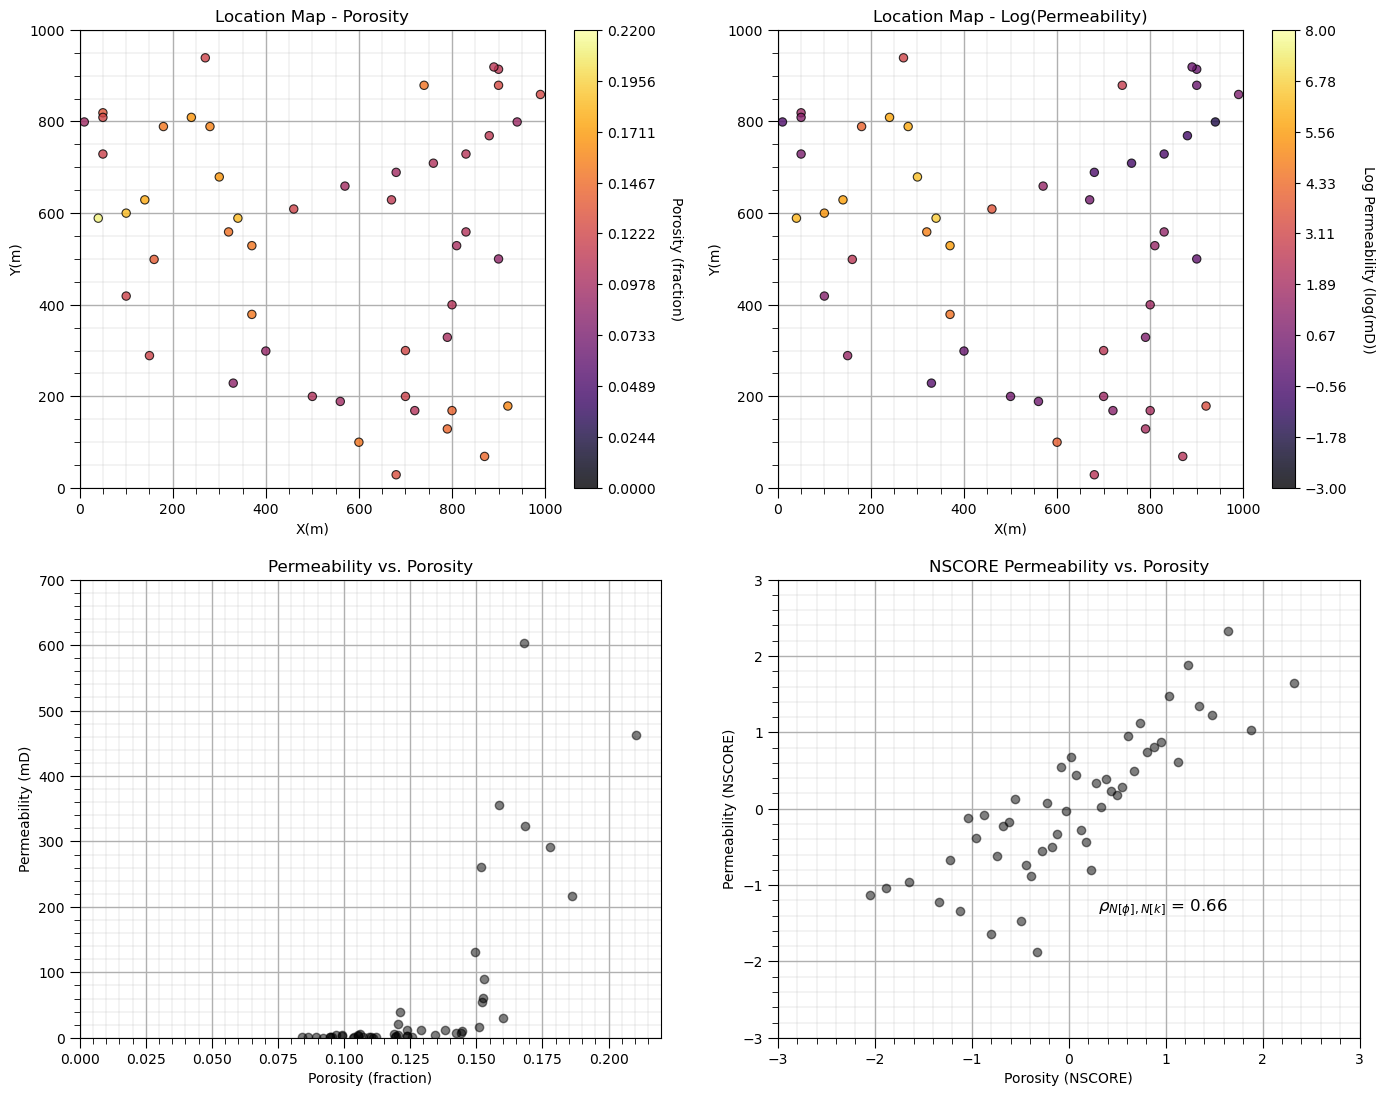

In [8]:
plt.subplot(221)                                              # plot porosity data
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Location Map - Porosity','X(m)','Y(m)',
                'Porosity (fraction)',cmap); add_grid()

plt.subplot(222)                                              # plot log permeability data
GSLIB.locmap_st(df,'X','Y','logPerm',xmin,xmax,ymin,ymax,logpermmin,logpermmax,'Location Map - Log(Permeability)',
                'X(m)','Y(m)','Log Permeability (log(mD))',cmap); add_grid()

plt.subplot(223)                                              # cross plot log permeability and porosity
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=0.5)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax]); add_grid()

plt.subplot(224)                                              # cross plot log permeability and porosity
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=0.5)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Permeability (NSCORE)');plt.title('NSCORE Permeability vs. Porosity')

corr = np.corrcoef(df['nPorosity'].values,df['nPerm'].values)[0,1]
plt.annotate(r'$\rho_{N[\phi],N[k]}$ = ' + str(np.round(corr,2)), (0.3,-1.35),size=12)

plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax]); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

Note we have already demonstrated univariate simulation checks for:

* data reproduction at data locations
* histogram reproduction 
* variogram reproduction

in these workflows:

* [kriging vs. simulation](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_kriging_vs_simulation.ipynb)
* [model checking](https://github.com/GeostatsGuy/GeostatsPyDemos/blob/main/GeostatsPy_model_checking.ipynb)

So for brevity, won't repeat these checks here. Also we will just assume reasonable variogram models for demonstration; therefore, no variogram calculation and modeling.

* let's focus on reproduction of the relationship between porosity and permeability

#### Independent Sequential Gaussian Simulation of Two Features

Let's jump right to building two independent simulations and visualizing the results. 

* independently simulate porosity and permeability 
* check the porosity an permeability relationship, the scatter plot.

In [9]:
%%capture --no-display     

sim_por = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=pormin,zmax=pormax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seed,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,
            sec_map=0,vario=npor_vario)[0]

sim_perm = geostats.sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=permmin,zmax=permmax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seed+1,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,
            sec_map=0,vario=nperm_vario)[0]

Visualize porosity and permeability realizations and the porosity vs. permeability relationship for independently simulation realizations.

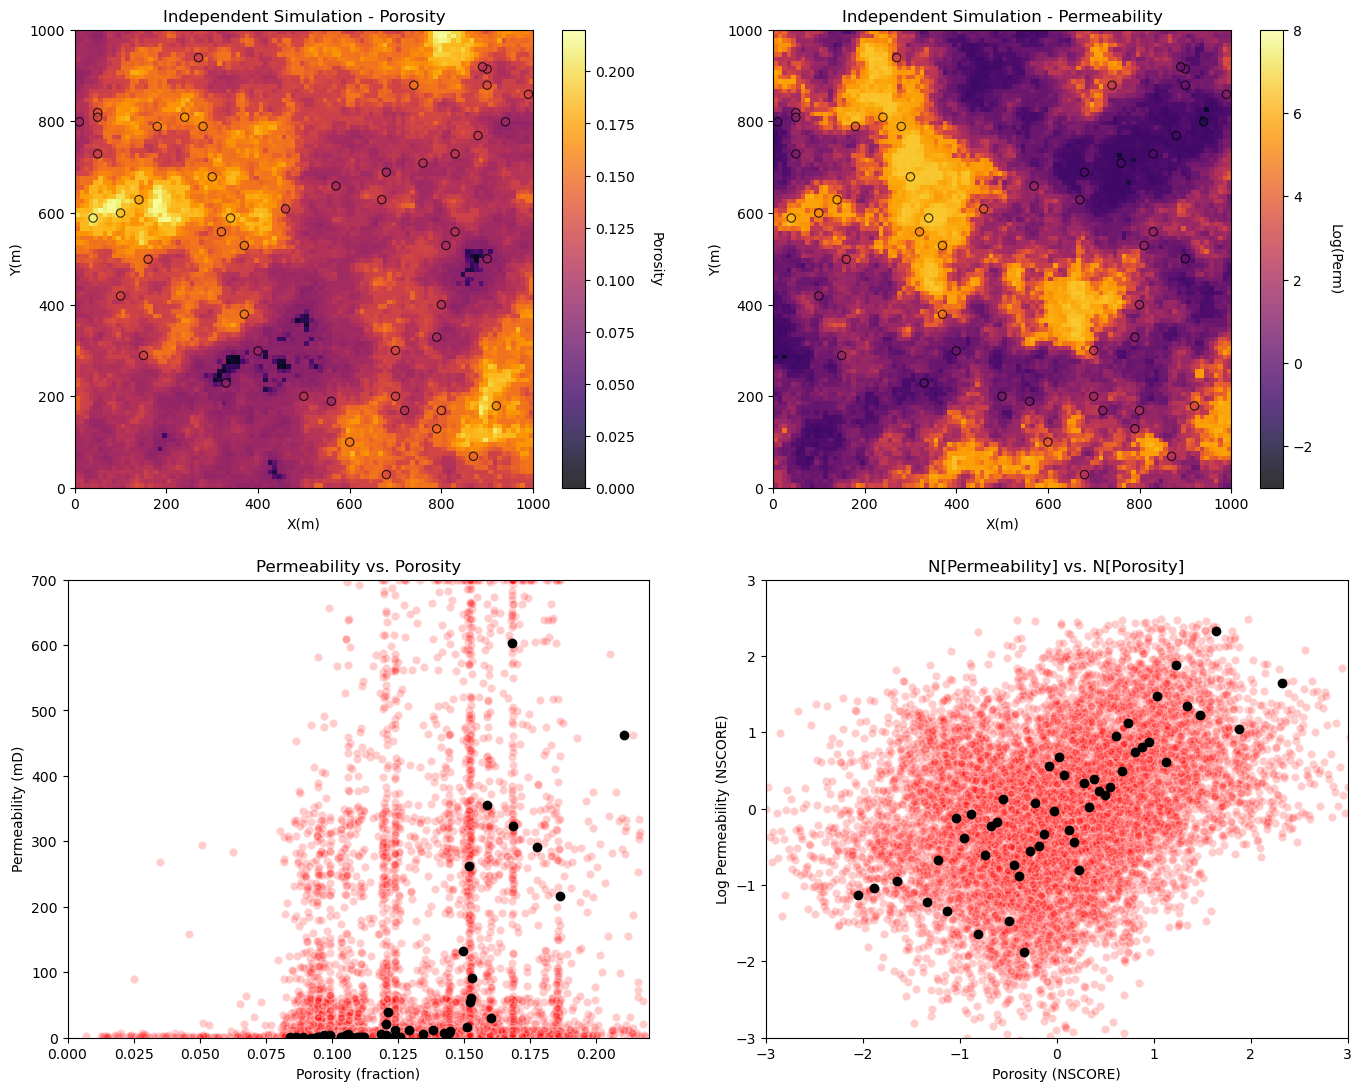

In [10]:
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Independent Simulation - Porosity','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(np.log(sim_perm),xmin,xmax,ymin,ymax,xsiz,logpermmin,logpermmax,df,'X','Y','logPerm','Independent Simulation - Permeability','X(m)','Y(m)','Log(Perm)',cmap)

plt.subplot(223)
plt.scatter(sim_por.flatten(),sim_perm.flatten(),color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax])

sim_npor = geostats.nscore(df=pd.DataFrame(sim_por.flatten(),columns=['sim_perm']),vcol='sim_perm')[0]
sim_nperm = geostats.nscore(df=pd.DataFrame(sim_perm.flatten(),columns=['sim_perm']),vcol='sim_perm')[0]

plt.subplot(224)
plt.scatter(sim_npor,sim_nperm,color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Log Permeability (NSCORE)');plt.title('N[Permeability] vs. N[Porosity]')
plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Sequential Gaussian Simulation with Collocated Cokriging

Now let's demonstrate collocated cokriging.  

1. calculate a realization of porosity - DONE - we will use the porosity realization from above! 
2. collocated cokriging realization of permeability constrained to the porosity realization

In [11]:
%%capture --no-display  

cosim_perm = geostats.sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1000.0,ltail=1,ltpar=0.0,utail=1,utpar=1000.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
            ktype=4,colocorr=corr,sec_map=sim_por,vario=nperm_vario)[0]

Visualize porosity and permeability realizations and the porosity vs. permeability relationship for independently simulation realizations.

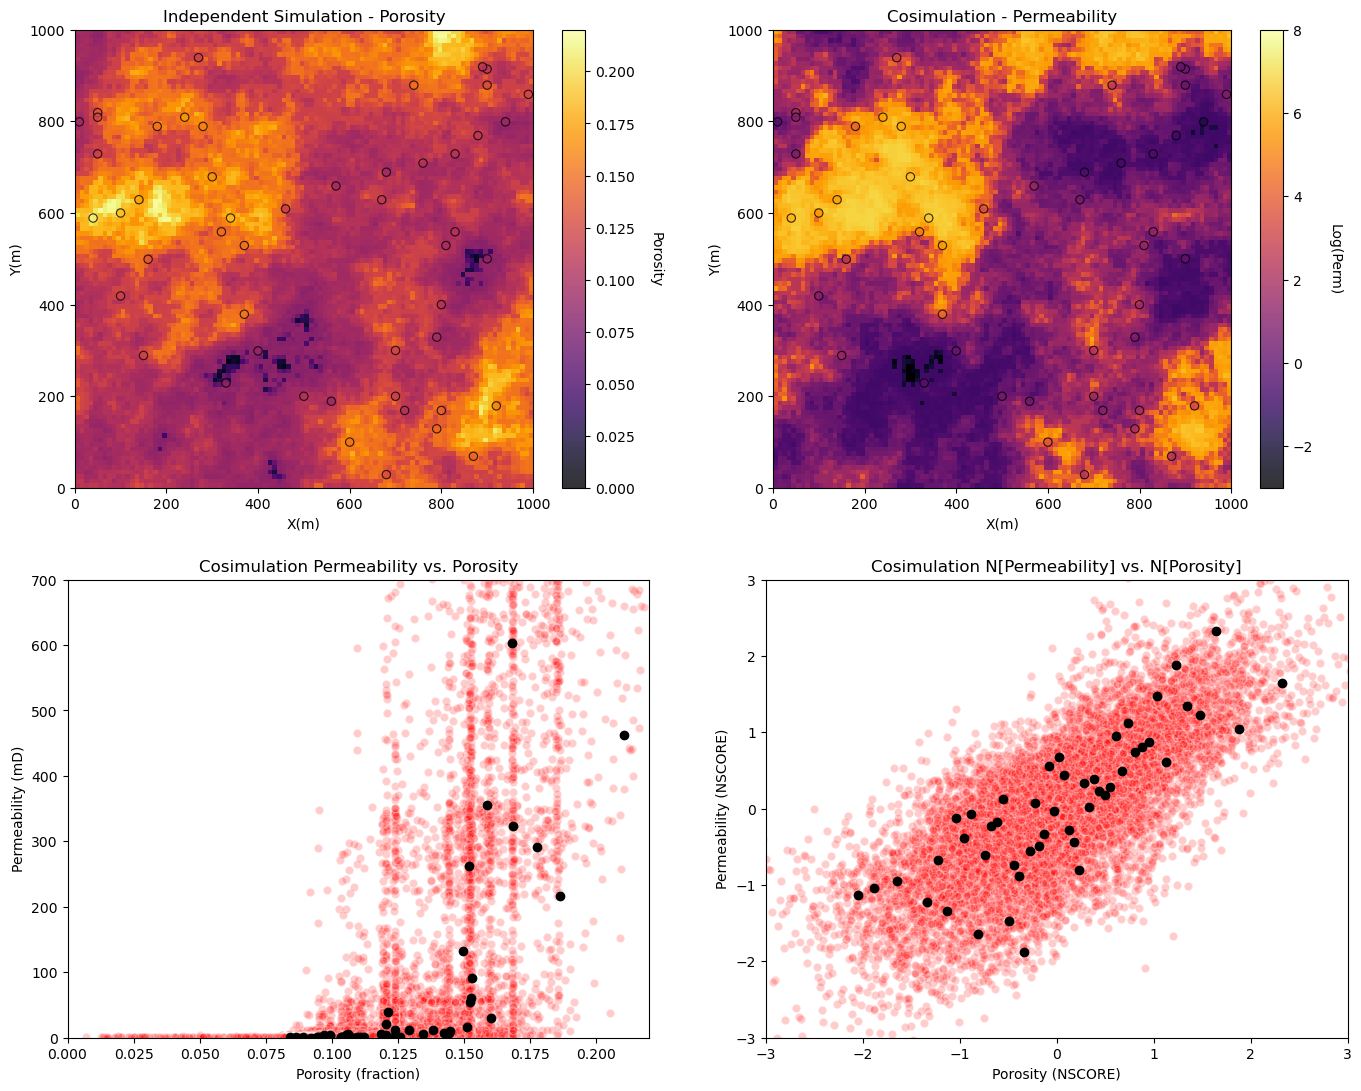

In [12]:
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Independent Simulation - Porosity','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(np.log(cosim_perm),xmin,xmax,ymin,ymax,xsiz,logpermmin,logpermmax,df,'X','Y','logPerm','Cosimulation - Permeability','X(m)','Y(m)','Log(Perm)',cmap)

plt.subplot(223)
plt.scatter(sim_por.flatten(),cosim_perm.flatten(),color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Cosimulation Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax])

sim_npor = geostats.nscore(df=pd.DataFrame(sim_por.flatten(),columns=['sim_perm']),vcol='sim_perm')[0]
cosim_nperm = geostats.nscore(df=pd.DataFrame(cosim_perm.flatten(),columns=['sim_perm']),vcol='sim_perm')[0]

plt.subplot(224)
plt.scatter(sim_npor,cosim_nperm,color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Permeability (NSCORE)');plt.title('Cosimulation N[Permeability] vs. N[Porosity]')
plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Compare the Secondary to Primary Relationship

Let's put all the cross plots together.

* **data imposes correlation** - at data and within the variogram range from data, the data correlation is imposed to some degree. This is why we don't see independence between the features with independent simulation.

* **unrealistic combinations** - of features occur with out cosimulation!

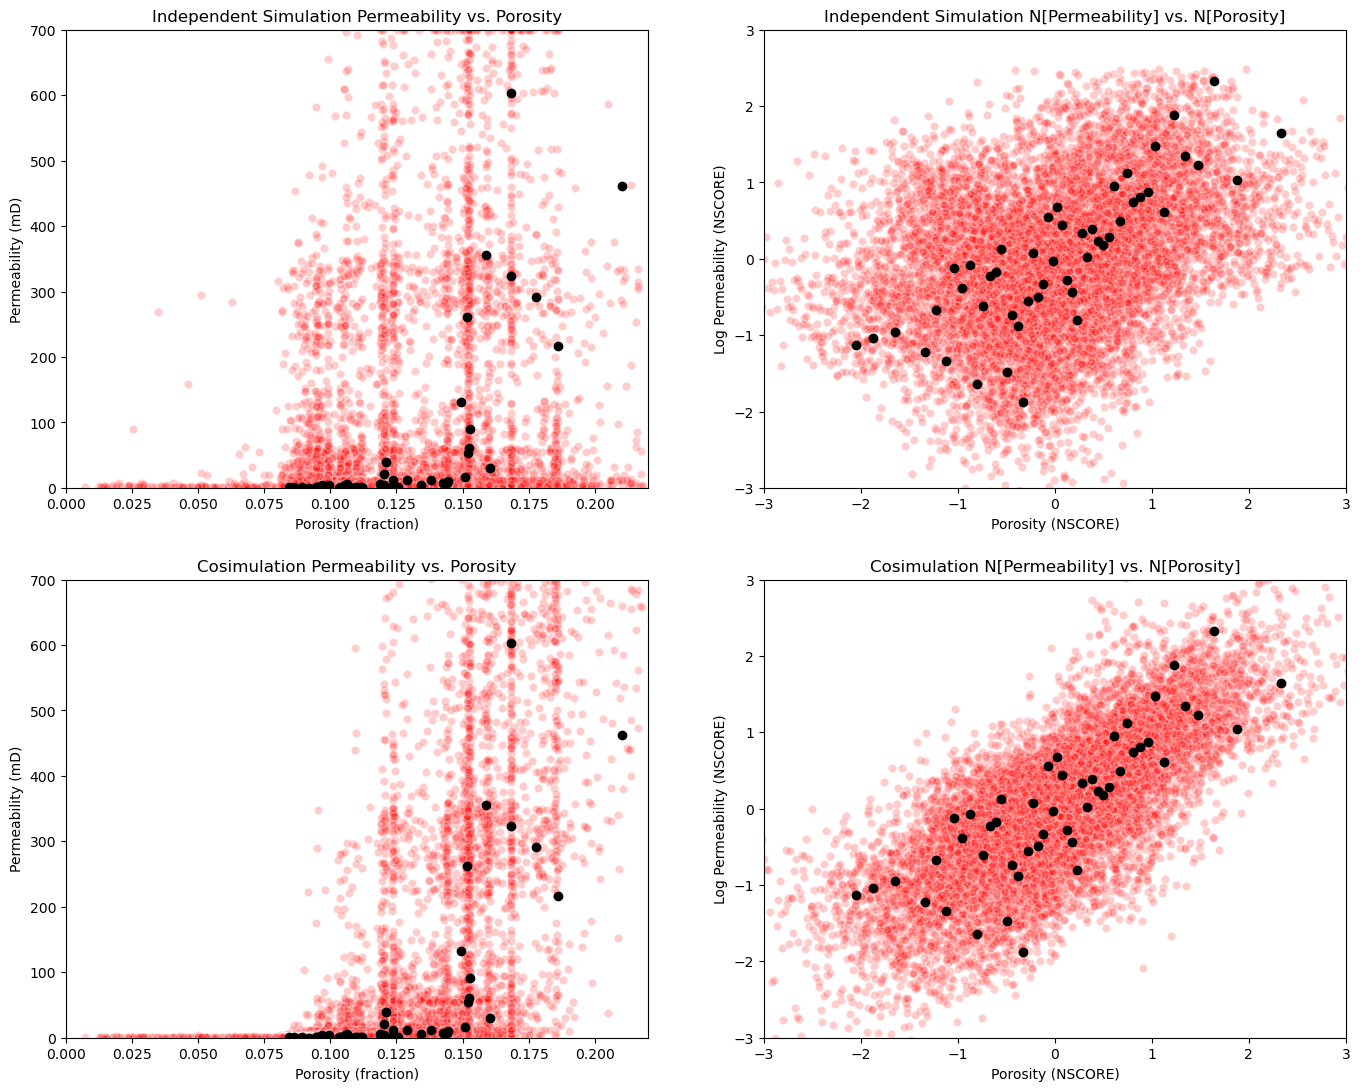

In [13]:
plt.subplot(221)
plt.scatter(sim_por.flatten(),sim_perm.flatten(),color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Independent Simulation Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax])

plt.subplot(222)
plt.scatter(sim_npor,sim_nperm,color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Log Permeability (NSCORE)');plt.title('Independent Simulation N[Permeability] vs. N[Porosity]')
plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax])

plt.subplot(223)
plt.scatter(sim_por.flatten(),cosim_perm.flatten(),color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Cosimulation Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax])

plt.subplot(224)
plt.scatter(sim_npor,cosim_nperm,color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Log Permeability (NSCORE)');plt.title('Cosimulation N[Permeability] vs. N[Porosity]')
plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration and comparison of cosimulation vs. independent simulation with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)